# TRABAJO DE FIN DE MÁSTER - Gemma del Val

## Clasificación de imágenes de células sanguíneas en pacientes infectados y no infectados de malaria mediante técnicas de Aprendizaje Profundo

## Índice

<a href='#Introducción'>1. Introducción</a><br>
<a href='#Análisis Exploratorio de los Datos'>2. Análisis Exploratorio de los Datos</a><br>
<a href='#Creación del conjunto de reserva'>3. Creación del conjunto de reserva</a><br>
<a href='#División de datos en train y test'>4. División de datos en train y test</a><br>
<a href='#Entrenamiento del modelo'>5. Entrenamiento del modelo</a><br>
<a href='#Análisis de errores'>6. Análisis de errores</a><br>
<a href='#Validación cruzada de 5 iteraciones'>7. Validación cruzada de 5 iteraciones</a><br>
<a href='#Entrenamiento del modelo final'>8. Entrenamiento del modelo final</a><br>
<a href='#Evaluación del modelo final en el conjunto de reserva'>9. Evaluación del modelo final en el conjunto de reserva</a><br>
<a href='#Referencias'>10. Referencias</a><br>

## 1. Introducción

El presente código en *python* corresponde al utilizado para la realización del trabajo de clasificación de imágenes. Nótese que a pesar de que el código está comentado, las explicaciones de la metodología utilizada así como las conclusiones y referencias se encuentran en la memoria del trabajo. 

Asimismo, comentar que este código ha sido compartido públicamente en la web de **Kaggle** como un *kernel* asociado a los datos que se han utilizado para la realización del mismo. El *link* es el siguiente: https://www.kaggle.com/gemmad/proceso-de-evaluaci-n-m-ster-big-data-b-a

También se ha creado un vídeo a modo de **elevator pitch**. El *link* es el siguiente: https://youtu.be/hy4p-VdUxNg

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import os
# Establecemos la semilla para asegurarnos que los resultados se repitan
from numpy.random import seed
seed(123)
import tensorflow
tensorflow.random.set_seed(123)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import itertools
import shutil
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Estas líneas de código nos permiten instalar opencv desde Jupyter Notebook, que vamos a necesitar para 
# importar 'cv2'
import sys
!{sys.executable} -m pip install opencv-python --user

In [3]:
# Importamos la biblioteca de visión artificial que vamos a utilizar en el trabajo
import cv2

In [4]:
# Definimos las medidas de algunas de las variables que vamos a utilizar más adelante
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96
NUM_HOLDOUT_IMAGES = 200
NUM_EPOCHS = 10
NUM_FOLDS = 5
PADDING = 10
BATCH_SIZE = 10
NUM_FINAL_MODEL_EPOCHS = 10

## 2. Análisis Exploratorio de los Datos

### Importación de los datos

In [5]:
# Establecemos el directorio en el que se encuentran las imágenes
path_sanos = '/Users/gemma/Desktop/cell_images/Uninfected'
path_infectados = '/Users/gemma/Desktop/cell_images/Parasitized'
lista_sanos = os.listdir(path_sanos)
lista_infectados = os.listdir(path_infectados)
# Comprobamos el número de imágenes que corresponden a cada tipo de paciente
print('Número de imágenes correspondientes a pacientes sanos:', len(lista_sanos))
print('Número de imágenes correspondientes a pacientes infectados:', len(lista_infectados))

Número de imágenes correspondientes a pacientes sanos: 13780
Número de imágenes correspondientes a pacientes infectados: 13780


### Visualización de imágenes

/Library/Python/3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


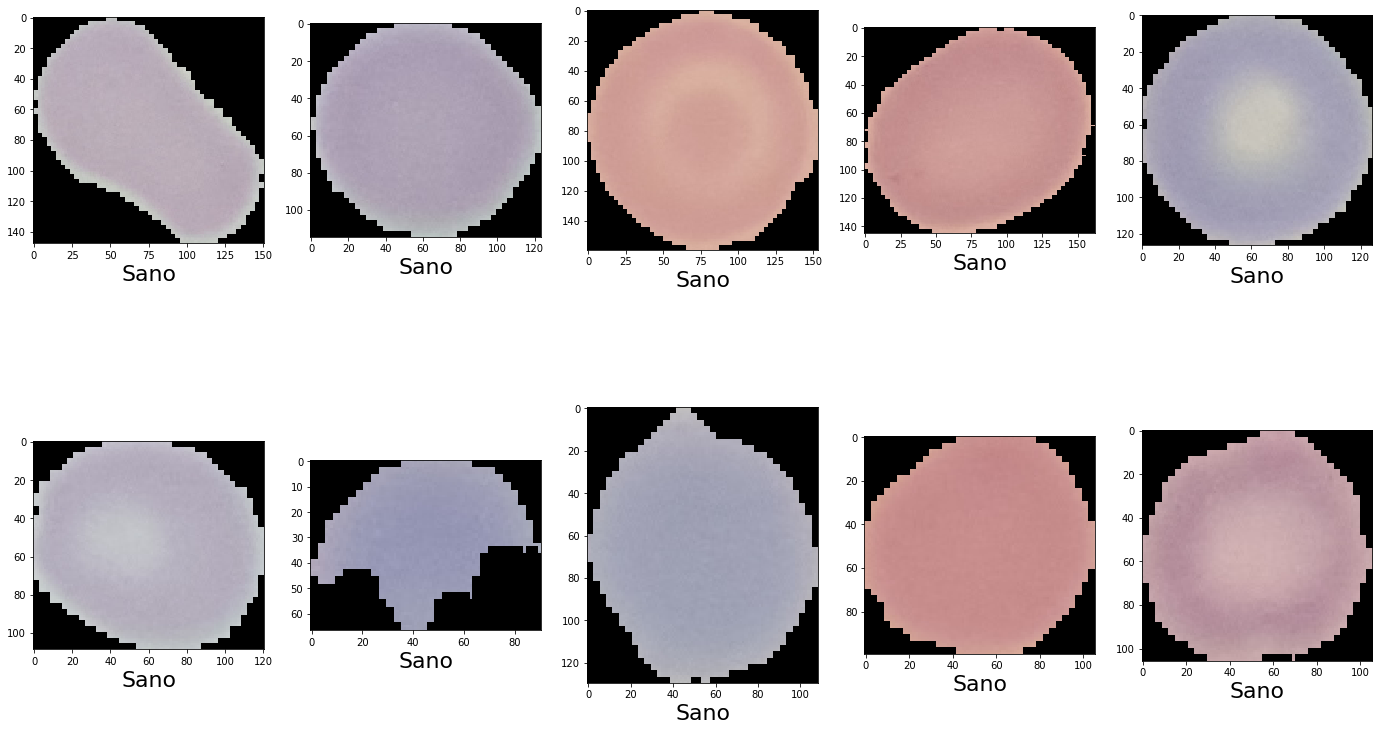

In [6]:
path_sanos = '/Users/gemma/Desktop/cell_images/Uninfected/'
path_infectados = '/Users/gemma/Desktop/cell_images/Parasitized/'
# Establecemos el tamaño de cada casilla, así como su disposición (número de filas y columnas)
plt.figure(figsize=(24,14))
plt.subplot(2,5,1)
# Vamos a desplegar diez imágenes en total
for i in range(1,11):
    plt.subplot(2,5,i)
# Van a ser imágenes elegidas al azar
    image = lista_sanos[i] 
    plt.imshow(plt.imread(path_sanos + image))
# Indicamos el texto que va a haber debajo de cada imagen así como el tamaño de su fuente, en este caso, 'Sano'
    plt.xlabel('Sano', fontsize=22)

/Library/Python/3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


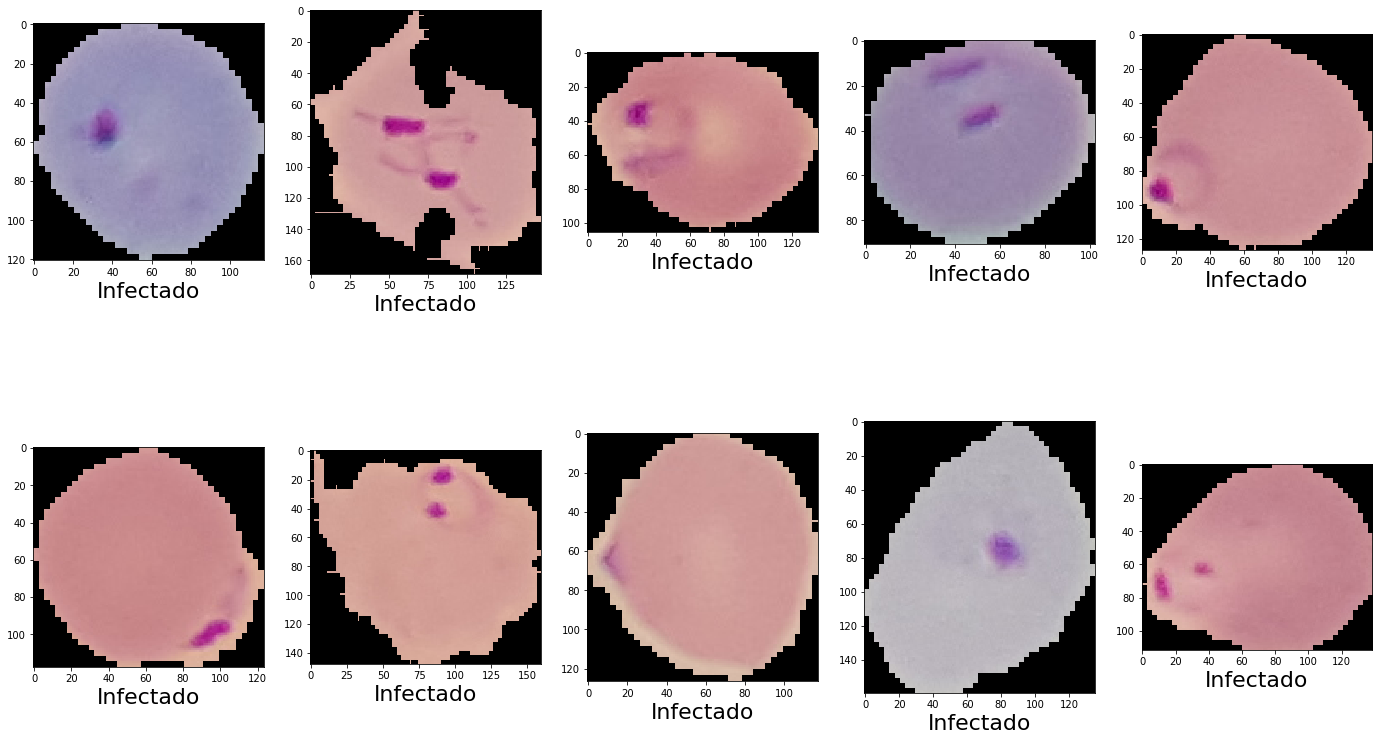

In [7]:
path_sanos = '/Users/gemma/Desktop/cell_images/Uninfected/'
path_infectados = '/Users/gemma/Desktop/cell_images/Parasitized/'
# Repetimos los pasos para las imágenes de infectados
plt.figure(figsize=(24,14))
plt.subplot(2,5,1)
for i in range(1,11):
    plt.subplot(2,5,i)
    image = lista_infectados[i]  
    plt.imshow(plt.imread(path_infectados + image))
    plt.xlabel('Infectado', fontsize=22)

### ¿Existe algún tipo de archivo que no sea una imagen?

In [8]:
# A continuación, comprobamos si hay algún archivo que no sea una imagen en la carpeta de sanos, ya que esto 
# podría traer problemas
for item in lista_sanos:
# Utilizamos la función .split()
lista_archivo = item.split('.')
# Comprobamos si hay algún caso en el que la extensión del archivo no sea la de una imagen, es decir, .png
    if lista_archivo[1] != 'png':
        print('Carpeta de sanos:', item)

Carpeta de sanos: Thumbs.db


In [9]:
# Repetimos los pasos para la carpeta de infectados
for item in lista_infectados:
    lista_archivo = item.split('.')
    if lista_archivo[1] != 'png':
        print('Carpeta de infectados:',item)

Carpeta de infectados: Thumbs.db


### Organización de las imágenes en dataframes

In [10]:
# Creamos un dataframe de la carpeta de sanos y eliminamos el archivo que no es una imagen
df_sanos = pd.DataFrame(lista_sanos, columns=['image_id'])
df_sanos = df_sanos[df_sanos['image_id'] != 'Thumbs.db']
# Añadimos una columna objetivo o 'target'
df_sanos['target'] = 0
# Repetimos el proceso para los infectados
df_infectados = pd.DataFrame(lista_infectados, columns=['image_id'])
df_infectados = df_infectados[df_infectados['image_id'] != 'Thumbs.db']
df_infectados['target'] = 1
# Creamos otro dataframe que combine los dos anteriores
df_combinado = pd.concat([df_sanos, df_infectados], axis=0).reset_index(drop=True)

In [11]:
# Observamos los seis primeros datos o imágenes que aparecen
df_combinado.head(6)

,image_id,target
0,C13NThinF_IMG_20150614_131318_cell_179.png,0
1,C205ThinF_IMG_20151106_152003_cell_21.png,0
2,C230ThinF_IMG_20151112_150647_cell_1.png,0
3,C134P95ThinF_IMG_20151005_121834_cell_65.png,0
4,C141P102ThinF_IMG_20151005_214836_cell_132.png,0
5,C167P128ReThinF_IMG_20151201_105559_cell_61.png,0


In [12]:
# Comprobamos la forma del dataframe creado en combinación de los dos anteriores
df_combinado.shape

(27558, 2)

In [13]:
# Tenemos que verificar que los nombres de las imágenes sean únicos, debería salir el mismo resultado 
# que el número de filas de la línea de código anterior
df_combinado['image_id'].nunique()

27558

### Tamaño de las imágenes y canales

In [14]:
# Comprobamos con las siguientes líneas de código la forma de las seis imágenes previamente seleccionadas, con el
# width y height (anchura y altura, representados como 'w' y 'h'), los canales, que son imágenes en escala de 
# grises del mismo tamaño que la imagen en color, hecha de cada uno de los colores primarios (en imagen digital: 
# verde, azul y rojo), así como el valor máximo y mínimo de píxeles (para averiguar si ha tenido lugar algún tipo 
# de preprocesado) y para finalizar añadimos esta información al dataframe original
def tamano_imagenes(file_name):    
    path_sanos = '/Users/gemma/Desktop/cell_images/Uninfected/'
    path_infectados = '/Users/gemma/Desktop/cell_images/Parasitized/' 
    if file_name in lista_sanos:
        path = path_sanos
    else:
        path = path_infectados   
    image = cv2.imread(path + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    img_format = file_name.split('.')[1]
    output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val, img_format]
    return output
m = np.stack(df_combinado['image_id'].apply(tamano_imagenes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_valor','min_pixel_valor', 'imagen_formato'])
df_combinado = pd.concat([df_combinado,df],axis=1, sort=False)
df_combinado.head(6)

,image_id,target,w,h,c,max_pixel_valor,min_pixel_valor,imagen_formato
0,C13NThinF_IMG_20150614_131318_cell_179.png,0,127,115,3,226,0,png
1,C205ThinF_IMG_20151106_152003_cell_21.png,0,148,151,3,211,0,png
2,C230ThinF_IMG_20151112_150647_cell_1.png,0,115,124,3,204,0,png
3,C134P95ThinF_IMG_20151005_121834_cell_65.png,0,160,154,3,221,0,png
4,C141P102ThinF_IMG_20151005_214836_cell_132.png,0,145,163,3,223,0,png
5,C167P128ReThinF_IMG_20151201_105559_cell_61.png,0,127,127,3,205,0,png


In [15]:
# Verificamos que todas las imágenes tengan los tres canales que acabamos de mencionar
df_combinado['c'].value_counts()

3    27558
Name: c, dtype: int64

In [16]:
# Comprobamos que todas las imágenes tengan formato .png
df_combinado['imagen_formato'].value_counts()

png    27558
Name: imagen_formato, dtype: int64

In [17]:
# Nos cercioramos de que no haya ninguna imagen en negro
len(df_combinado[(df_combinado['max_pixel_valor'] == 0) & (df_combinado['max_pixel_valor'] == 0)])

0

In [18]:
# Hacemos lo mismo para las imágenes en blanco
len(df_combinado[(df_combinado['max_pixel_valor'] == 255) & (df_combinado['max_pixel_valor'] == 255)])

0

## 3. Creación del conjunto de reserva

In [21]:
# Reorganizamos las imágenes con el método shuffle()
df_combinado = shuffle(df_combinado, random_state=123)
# Creamos un conjunto de reserva de 200 imágenes (definimos esta variable en la cuarta célula del Notebook)
df_aparte = df_combinado.sample(NUM_HOLDOUT_IMAGES, random_state=123)
lista_imagenes_aparte = list(df_aparte['image_id'])
# A continuación seleccionamos las filas que no forman parte del conjunto de reserva. Son las filas con las 
# que vamos a trabajar a partir de ahora
datos = df_combinado[~df_combinado['image_id'].isin(lista_imagenes_aparte)]

In [22]:
# Mostramos las primeras seis filas del conjunto de reserva, "df_aparte"
df_aparte.head(6)

,image_id,target,w,h,c,max_pixel_valor,min_pixel_valor,imagen_formato
1364,C114P75ThinF_IMG_20150930_150057_cell_103.png,0,136,127,3,222,0,png
27330,C180P141NThinF_IMG_20151201_163751_cell_185.png,1,130,136,3,204,0,png
9615,C168P129ThinF_IMG_20151118_161940_cell_142.png,0,130,142,3,210,0,png
14217,C80P41ThinF_IMG_20150817_111544_cell_141.png,1,151,181,3,211,0,png
20891,C181P142ThinF_IMG_20151127_160539_cell_187.png,1,112,121,3,213,0,png
15060,C158P119ThinF_IMG_20151115_181136_cell_201.png,1,127,118,3,205,0,png


In [23]:
# Mostramos las primeras seis filas del conjunto que no incluye al de reserva, al que hemos denominado "datos"
datos.head(6)

,image_id,target,w,h,c,max_pixel_valor,min_pixel_valor,imagen_formato
7468,C98P59ThinF_IMG_20150917_153600_cell_1.png,0,124,127,3,225,0,png
17333,C181P142ThinF_IMG_20151127_160616_cell_164.png,1,139,142,3,208,0,png
897,C148P109ThinF_IMG_20151115_112333_cell_176.png,0,154,154,3,213,0,png
17206,C129P90ThinF_IMG_20151004_133329_cell_111.png,1,133,142,3,234,0,png
27496,C112P73ThinF_IMG_20150930_131401_cell_166.png,1,172,157,3,237,0,png
5945,C45P6ThinF_IMG_20151130_160135_cell_124.png,0,124,124,3,218,0,png


In [24]:
# Comprobamos la forma de ambos conjuntos
print(df_aparte.shape)
print(datos.shape)

(200, 8)
(27358, 8)


In [25]:
# Vemos el número de imágenes de la variable objetivo en el conjunto de reserva para cada clase, siendo el 0
# para los sanos y el 1 para los infectados
df_aparte['target'].value_counts()

0    110
1     90
Name: target, dtype: int64

## 4. División de datos en train y validación

### Creación del directorio

In [26]:
# Iniciamos creando una carpeta en nuestro escritorio, "directorio_base"
directorio_base = 'directorio_base'
os.mkdir(directorio_base)
# Que contendrá dos carpetas, "train" y "validación"
train = os.path.join(directorio_base, 'train')
os.mkdir(train)
validacion = os.path.join(directorio_base, 'validacion')
os.mkdir(validacion)
# Y dentro de cada carpeta creamos otras dos diferenciando pacientes sanos de infectados
sanos_A = os.path.join(train, 'sanos_A')
os.mkdir(sanos_A)
infectados_B = os.path.join(train, 'infectados_B')
os.mkdir(infectados_B)
sanos_A = os.path.join(validacion, 'sanos_A')
os.mkdir(sanos_A)
infectados_B = os.path.join(validacion, 'infectados_B')
os.mkdir(infectados_B)

### Creación de los sets de train y validación

In [28]:
# Seleccionamos la columna que vamos a utilizar para dividir los datos; se aplica estratificación
y = datos['target']
train_df, validacion_df = train_test_split(datos, test_size=0.15, random_state=123, stratify=y)
# Comprobamos la forma de cada nuevo dataframe creado
print(train_df.shape)
print(validacion_df.shape)

(23254, 8)
(4104, 8)


In [29]:
# Verificamos que los datos de la variable objetivo están equilibrados para cada clase en el set de validación
validacion_df['target'].value_counts()

1    2054
0    2050
Name: target, dtype: int64

### Traslado de las imágenes a carpetas

In [30]:
# Establecemos 'image_id' como index de "datos"
datos.set_index('image_id', inplace=True)

In [31]:
# Visualizamos las primeras seis filas del conjunto
datos.head(6)

,target,w,h,c,max_pixel_valor,min_pixel_valor,imagen_formato
image_id,,,,,,,
C98P59ThinF_IMG_20150917_153600_cell_1.png,0,124,127,3,225,0,png
C181P142ThinF_IMG_20151127_160616_cell_164.png,1,139,142,3,208,0,png
C148P109ThinF_IMG_20151115_112333_cell_176.png,0,154,154,3,213,0,png
C129P90ThinF_IMG_20151004_133329_cell_111.png,1,133,142,3,234,0,png
C112P73ThinF_IMG_20150930_131401_cell_166.png,1,172,157,3,237,0,png
C45P6ThinF_IMG_20151130_160135_cell_124.png,0,124,124,3,218,0,png


In [32]:
# Iniciamos obteniendo listas de imágenes para cada carpeta
path_sanos = '/Users/gemma/Desktop/cell_images/Uninfected/'
path_infectados = '/Users/gemma/Desktop/cell_images/Parasitized/'
carpeta_1 = os.listdir(path_sanos)
carpeta_2 = os.listdir(path_infectados)
# Hacemos lo mismo para train y validación
lista_train = list(train_df['image_id'])
lista_validacion = list(validacion_df['image_id'])
# Transferimos las imágenes de train
for image in lista_train:
    fname = image
    target = datos.loc[image,'target']
    if target == 0:
        label = 'sanos_A'
    else:
        label = 'infectados_B'
    if fname in carpeta_1:
# Hemos definido "ini" como origen y "fin" como destino
# Directorio de origen
        ini = os.path.join(path_sanos, fname)
# Directorio de destino
        fin = os.path.join(train, label, fname)
        image = cv2.imread(ini)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
# Guardamos las imágenes en destino
        cv2.imwrite(fin, image)
    if fname in carpeta_2:
        ini = os.path.join(path_infectados, fname)
        fin = os.path.join(train, label, fname)
        image = cv2.imread(ini)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(fin, image)      
# Repetimos el proceso para las imágenes de validación
for image in lista_validacion:
    fname = image
    target = datos.loc[image,'target']
    if target == 0:
        label = 'sanos_A'
    else:
        label = 'infectados_B'
    if fname in carpeta_1:
        ini = os.path.join(path_sanos, fname)
        fin = os.path.join(validacion, label, fname)
        image = cv2.imread(ini)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(fin, image)
    if fname in carpeta_2:
        ini = os.path.join(path_infectados, fname)
        fin = os.path.join(validacion, label, fname)
        image = cv2.imread(ini)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(fin, image)

In [33]:
# Verificamos el número de imágenes en cada carpeta
# Set de train
print(len(os.listdir('directorio_base/train/sanos_A')))
print(len(os.listdir('directorio_base/train/infectados_B/')))
# Set de validación
print(len(os.listdir('directorio_base/validacion/sanos_A')))
print(len(os.listdir('directorio_base/validacion/infectados_B/')))

11619
11635
2050
2054


### Generators

In [34]:
# Volvemos a hacer uso de algunas variables que habíamos previamente establecido en la célula cuatro, como
# BATCH_SIZE (o tamaño del lote) = 10
path_train = 'directorio_base/train'
path_validacion = 'directorio_base/validacion'
train_mu = len(train_df)
validacion_mu = len(validacion_df)
batch_size_train = BATCH_SIZE
batch_size_validacion = BATCH_SIZE
pasos_train = np.ceil(train_mu / batch_size_train)
pasos_validacion = np.ceil(validacion_mu / batch_size_validacion)

In [35]:
# Normalizamos las imágenes dentro del 'generator'
datagen = ImageDataGenerator(rescale=1.0/255)
gen_train = datagen.flow_from_directory(path_train,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=batch_size_train,
                                        class_mode='categorical')
gen_validacion = datagen.flow_from_directory(path_validacion,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=batch_size_validacion,
                                        class_mode='categorical')
# Indicamos shuffle=False en la última línea de código para que el dataset no sea reorganizado
gen_test = datagen.flow_from_directory(path_validacion,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=batch_size_validacion,
                                        class_mode='categorical',
                                        shuffle=False)

Found 23254 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.


## 5. Entrenamiento del modelo

### Establecimiento de las características del modelo

In [36]:
# Arquitectura del modelo obtenida de GitHub. Fuente: https://gist.github.com/Mishaall/f52e717eae11080c
# 4fc530e9ef5082ff
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.3
modelo = Sequential()
modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
modelo.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))
modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = pool_size)) 
modelo.add(Dropout(dropout_conv))
modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
modelo.add(MaxPooling2D(pool_size = pool_size))
modelo.add(Dropout(dropout_conv))
modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
modelo.add(MaxPooling2D(pool_size = pool_size))
modelo.add(Dropout(dropout_conv))
modelo.add(Flatten())
modelo.add(Dense(256, activation = "relu"))
modelo.add(Dropout(dropout_dense))
modelo.add(Dense(2, activation = "softmax"))
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 114, 114, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 64)        1

### Entrenamiento del modelo

In [37]:
modelo.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [38]:
# Fuente para la arquitectura: https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')          
lista_callbacks = [checkpoint]
history = modelo.fit(gen_train, steps_per_epoch=pasos_train, 
                            validation_data=gen_validacion,
                            validation_steps=pasos_validacion,
                            epochs=NUM_EPOCHS, verbose=1,
                           callbacks=lista_callbacks)

Epoch 1/10
2326/2326 [==============================] - 2035s 875ms/step - loss: 0.3188 - accuracy: 0.8417 - val_loss: 0.1575 - val_accuracy: 0.9522
Epoch 2/10
2326/2326 [==============================] - 2035s 875ms/step - loss: 0.1444 - accuracy: 0.9537 - val_loss: 0.1358 - val_accuracy: 0.9557
Epoch 3/10
2326/2326 [==============================] - 2366s 1s/step - loss: 0.1354 - accuracy: 0.9568 - val_loss: 0.1359 - val_accuracy: 0.9527
Epoch 4/10
2326/2326 [==============================] - 2160s 929ms/step - loss: 0.1302 - accuracy: 0.9576 - val_loss: 0.1307 - val_accuracy: 0.9547
Epoch 5/10
2326/2326 [==============================] - 1949s 838ms/step - loss: 0.1237 - accuracy: 0.9590 - val_loss: 0.1339 - val_accuracy: 0.9515
Epoch 6/10
2326/2326 [==============================] - 1855s 798ms/step - loss: 0.1184 - accuracy: 0.9612 - val_loss: 0.1199 - val_accuracy: 0.9598
Epoch 7/10
2326/2326 [==============================] - 1851s 796ms/step - loss: 0.1119 - accuracy: 0.9628 - 

### Valoración del modelo con el set de validación

In [39]:
# Comprobamos el nombre de las medidas
modelo.metrics_names

['loss', 'accuracy']

In [40]:
# Importamos el paquete necesario para poder guardar el modelo
import h5py
from keras.models import load_model
modelo.save('model.h5')

Using TensorFlow backend.


In [41]:
# Utilizaremos la mejor repetición o epoch
modelo.load_weights("model.h5")
val_loss, val_acc = \
modelo.evaluate(gen_test, 
                        steps=pasos_validacion)
print('val_loss:', val_loss)
print('val_acc:', val_acc)

411/411 [==============================] - 66s 162ms/step - loss: 0.1195 - accuracy: 0.9600
val_loss: 0.11945617944002151
val_acc: 0.960038959980011


### Representación gráfica de las curvas de loss y accuracy

<Figure size 432x288 with 0 Axes>

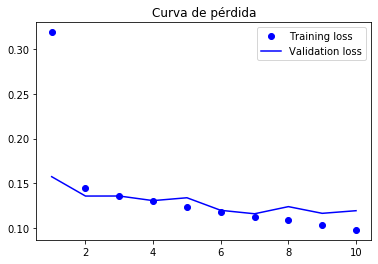

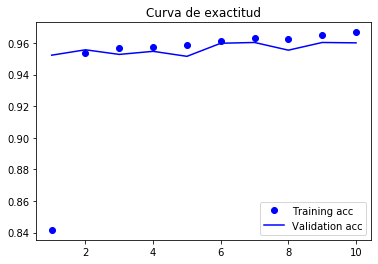

<Figure size 432x288 with 0 Axes>

In [45]:
# Procederemos a representar gráficamente la curva de pérdida ('loss') y la de exactitud ('accuracy')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Curva de pérdida')
plt.legend()
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Curva de exactitud')
plt.legend()
plt.figure()

### Confusion Matrix

In [46]:
# Obtenemos las etiquetas para las imágenes de test
test_etiquetas = gen_test.classes

In [47]:
test_etiquetas

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [48]:
# Mostramos la etiqueta y su clase asociada
gen_test.class_indices

{'infectados_B': 0, 'sanos_A': 1}

In [49]:
# Realizamos una predicción
predicciones = modelo.predict(gen_test, steps=pasos_validacion, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
411/411 [==============================] - 75s 182ms/step


In [51]:
# Comprobamos el número de predicciones
predicciones.shape

(4104, 2)

In [43]:
# Con la siguiente función creamos la Confusion Matrix. Se puede aplicar normalización con normalize=True,
# pero decidimos no aplicarla
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix normalizada")
    else:
        print('Confusion matrix, sin normalizar')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')
    plt.tight_layout()

In [53]:
# Mostramos la forma del dataframe
test_etiquetas.shape

(4104,)

In [54]:
# A continuación hacemos uso de argmax(), que es una función que proporciona el índice del mayor número en la
# fila o columna dada y la fila o columna se puede decidir utilizando el atributo de eje de argmax función. 
# Si damos axis=0 entonces dará el índice de las columnas y si damos axis=1 entonces dará el índice de las filas.
cm = confusion_matrix(test_etiquetas, predicciones.argmax(axis=1))

In [55]:
# Mostramos de nuevo la etiqueta y su clase asociada
gen_test.class_indices

{'infectados_B': 0, 'sanos_A': 1}

Confusion matrix, sin normalizar
[[1962   92]
 [  72 1978]]


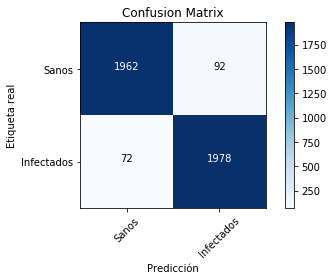

In [56]:
# Indicamos cómo se van a llamar las etiquetas en la 'Confusion Matrix'
cm_plot_etiquetas = ['Sanos', 'Infectados']
plot_confusion_matrix(cm, cm_plot_etiquetas, title='Confusion Matrix')

### Informe de clasificación

In [57]:
# Para obtener la secuencia en la que el generator ha procesado las imágenes de test
test_nombres = gen_test.filenames
# Obtenemos las etiquetas reales, es decir, si la imagen se corresponde a una persona infectada o no
y_real = gen_test.classes
# Así como las etiquetas de las predicciones
y_prediccion = predicciones.argmax(axis=1)

In [58]:
# Hacemos una tabla para verlo con mayor claridad
clasificacion = classification_report(y_real, y_prediccion, target_names=cm_plot_etiquetas)
print(clasificacion)

              precision    recall  f1-score   support

       Sanos       0.96      0.96      0.96      2054
  Infectados       0.96      0.96      0.96      2050

    accuracy                           0.96      4104
   macro avg       0.96      0.96      0.96      4104
weighted avg       0.96      0.96      0.96      4104



## 6. Análisis de errores

In [59]:
# Juntamos en un mismo dataframe image_id, las etiquetas y predicciones de validación
vali_pred_dict = {
    'image_id': gen_test.filenames,
    'vali_labels': gen_test.classes,
    'vali_preds': predicciones.argmax(axis=1)
}
# Creamos otro dataframe
df_vali_preds = pd.DataFrame(vali_pred_dict)
# Acortamos el nombre de los archivos
def adjust_file_names(x):
# Los dividimos en una lista basándonos en '/'
    fname = x.split('/')
# Elegimos el segundo elemento de la lista que es el nombre de la imagen
    fname = fname[1]
    return fname
df_vali_preds['image_id'] = df_vali_preds['image_id'].apply(adjust_file_names)
# Guardamos el último dataframe creado, "df_vali_preds" para poder analizar los resultados después
pickle.dump(df_vali_preds,open('df_vali_preds.pickle','wb'))

In [60]:
# Visualizamos las seis primeras filas del dataframe
df_vali_preds.head(6)

,image_id,vali_labels,vali_preds
0,C100P61ThinF_IMG_20150918_144104_cell_162.png,0,0
1,C100P61ThinF_IMG_20150918_144104_cell_166.png,0,1
2,C100P61ThinF_IMG_20150918_144104_cell_171.png,0,0
3,C100P61ThinF_IMG_20150918_144348_cell_142.png,0,1
4,C100P61ThinF_IMG_20150918_144823_cell_157.png,0,0
5,C100P61ThinF_IMG_20150918_145422_cell_167.png,0,0


In [61]:
# A continuación mostramos las filas para las que el modelo acertó en sus predicciones
df_correc = df_vali_preds[df_vali_preds['vali_labels'] == df_vali_preds['vali_preds']]
# Así como las filas en las que el modelo falló en sus predicciones
df_incorrec = df_vali_preds[df_vali_preds['vali_labels'] != df_vali_preds['vali_preds']]
print(df_correc.shape)
print(df_incorrec.shape)

(3940, 3)
(164, 3)


## 7. Validación cruzada de 5 iteraciones

In [63]:
# Iniciamos creando las cinco particiones o folds
# Para ello primero reorganizamos "df_combinado"
datos = shuffle(df_combinado.copy())
y = datos['target']
# Iniciamos con StratifiedKFold, que primero baraja los datos, luego los divide en 'n_splits' partes y después
# usará cada parte como un conjunto de prueba
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=123)
# Definimos la y
y = datos['target']
# Metemos todas las tuplas (cada fold es una tupla) en una lista
lista_fold = list(kf.split(datos, y))
# Creamos una lista para guardar las predicciones
vali_pred_list = []
# Y otra para los niveles de accuracy, loss y AUC
vali_acc_list = []
vali_loss_list = []
vali_auc_list = []
for i, fold in enumerate(lista_fold):
# Eliminamos el directorio que hemos creado anteriormente
    if os.path.isdir('directorio_base') == True:   
        shutil.rmtree('directorio_base')         
# Establecemos cuáles son los datos que se van a tratar
        datos = df_combinado.copy()    
    print('=== Fold_' + str(i) + ' ===')
    print('\n')
# Y los índices de train y validación como filas de un dataframe
    train_df = datos[datos.index.isin(fold[0])]
    validacion_df = datos[datos.index.isin(fold[1])]  
# Creamos un directorio nuevo
    directorio_base = 'directorio_base'
    os.mkdir(directorio_base)
# Repetimos el proceso de crear las carpetas diferenciadas para train y validación así como sus respectivos
# sanos e infectados en otras carpetas dentro de las primeras
    train = os.path.join(directorio_base, 'train')
    os.mkdir(train)
    validacion = os.path.join(directorio_base, 'validacion')
    os.mkdir(validacion)
    sanos_A = os.path.join(train, 'sanos_A')
    os.mkdir(sanos_A)
    infectados_B = os.path.join(train, 'infectados_B')
    os.mkdir(infectados_B)
    sanos_A = os.path.join(validacion, 'sanos_A')
    os.mkdir(sanos_A)
    infectados_B = os.path.join(validacion, 'infectados_B')
    os.mkdir(infectados_B)
# A continuación vamos a pasar las imágenes a las carpetas
# Establecemos image_id como el valor index de datos
    datos.set_index('image_id', inplace=True
# Y obtenemos una lista de imágenes para cada una de las dos carpetas
    path_sanos = '/Users/gemma/Desktop/cell_images/Uninfected/'
    path_infectados = '/Users/gemma/Desktop/cell_images/Parasitized/'
    carpeta_1 = os.listdir(path_sanos)
    carpeta_2 = os.listdir(path_infectados)
# Así como una lista para train y validación
    lista_train = list(train_df['image_id'])
    lista_validacion = list(validacion_df['image_id'])
# Transferimos las imágenes como hemos hecho en células de código anteriores
# En el caso de train, escribimos lo siguiente
    for image in lista_train:
        fname = image
        target = datos.loc[image,'target']
        if target == 0:
            label = 'sanos_A'
        else:
            label = 'infectados_B'
        if fname in carpeta_1:
# Como ya hemos explicado anteriormente, hemos definido "ini" como origen y "fin" como destino
# Para el directorio de origen, escribiremos la siguiente línea de código
            ini = os.path.join(path_sanos, fname)
# Para el directorio de destino
            fin = os.path.join(train, label, fname)
            image = cv2.imread(ini)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
# Guardamos las imágenes en destino
            cv2.imwrite(fin, image)
        if fname in carpeta_2:
            ini = os.path.join(path_infectados, fname)
            fin = os.path.join(train, label, fname)
            image = cv2.imread(ini)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            cv2.imwrite(fin, image)
# Repetimos el proceso para validación
    for image in lista_validacion:
        fname = image
        target = datos.loc[image,'target']
        if target == 0:
            label = 'sanos_A'
        else:
            label = 'infectados_B'
        if fname in carpeta_1:
            ini = os.path.join(path_sanos, fname)
            fin = os.path.join(validacion, label, fname)
            image = cv2.imread(ini)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            cv2.imwrite(fin, image)
        if fname in carpeta_2:
            ini = os.path.join(path_infectados, fname)
            fin = os.path.join(validacion, label, fname)
            image = cv2.imread(ini)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            cv2.imwrite(fin, image)
# Generadores o generators
    path_train = 'directorio_base/train'
    path_validacion = 'directorio_base/validacion'
    train_mu = len(train_df)
    validacion_mu = len(validacion_df)
    batch_size_train = BATCH_SIZE
    batch_size_validacion = BATCH_SIZE
    pasos_train = np.ceil(train_mu / batch_size_train)
    pasos_validacion = np.ceil(validacion_mu / batch_size_validacion)
    datagen = ImageDataGenerator(rescale=1.0/255)
    gen_train = datagen.flow_from_directory(path_train,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=batch_size_train,
                                            class_mode='categorical')
    gen_validacion = datagen.flow_from_directory(path_validacion,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=batch_size_train,
                                            class_mode='categorical')
# Indicamos shuffle=False en la última línea de código para que el dataset no sea reorganizado
    gen_test = datagen.flow_from_directory(path_validacion,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=batch_size_validacion,
                                            class_mode='categorical',
                                            shuffle=False)    
    print('\n') 
# Indicamos las características del modelo
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128
    dropout_conv = 0.3
    dropout_dense = 0.3
    modelo = Sequential()
    modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))    
    modelo.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))    
    modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    modelo.add(MaxPooling2D(pool_size = pool_size)) 
    modelo.add(Dropout(dropout_conv))
    modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    modelo.add(MaxPooling2D(pool_size = pool_size))
    modelo.add(Dropout(dropout_conv))
    modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    modelo.add(MaxPooling2D(pool_size = pool_size))
    modelo.add(Dropout(dropout_conv))
    modelo.add(Flatten())
    modelo.add(Dense(256, activation = "relu"))
    modelo.add(Dropout(dropout_dense))
    modelo.add(Dense(2, activation = "softmax"))
# ENTRENAMIENTO O TRAINING DEL MODELO
    modelo.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
                  metrics=['accuracy'])
    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                                 save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                       verbose=1, mode='max', min_lr=0.00001)
    lista_callbacks = [checkpoint, reduce_lr]
    history = modelo.fit(gen_train, steps_per_epoch=pasos_train, 
                                validation_data=gen_validacion,
                                validation_steps=pasos_validacion,
                                epochs=NUM_EPOCHS, verbose=1,
                               callbacks=lista_callbacks)
# EVALUAMOS EL MODELO EN VALIDACIÓN
    modelo.load_weights('model.h5')
    val_loss, val_acc = \
    modelo.evaluate_generator(gen_test, 
                            steps=pasos_validacion)    
# Utilizamos el método .append() la puntuación de accuracy y loss a las listas
    vali_acc_list.append(val_acc)
    vali_loss_list.append(val_loss)    
# Calculamos al puntuación de AUC
    test_etiquetas = gen_test.classes
# Realizamos una predicción
    predicciones = modelo.predict_generator(gen_test, steps=pasos_validacion, verbose=1)    
# Con .append() las añadimos a la lista
    vali_pred_list.append(predicciones)    
    vali_auc = roc_auc_score(test_etiquetas, predicciones.argmax(axis=1))   
    vali_auc_list.append(vali_auc)       

=== Fold_0 ===


Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


Epoch 1/10
2205/2205 [==============================] - 1869s 848ms/step - loss: 0.3686 - accuracy: 0.8213 - val_loss: 0.1683 - val_accuracy: 0.9499
Epoch 2/10
2205/2205 [==============================] - 1999s 907ms/step - loss: 0.1486 - accuracy: 0.9544 - val_loss: 0.1524 - val_accuracy: 0.9499
Epoch 3/10
2205/2205 [==============================] - 2677s 1s/step - loss: 0.1394 - accuracy: 0.9565 - val_loss: 0.1523 - val_accuracy: 0.9528
Epoch 4/10
2205/2205 [==============================] - 2922s 1s/step - loss: 0.1330 - accuracy: 0.9576 - val_loss: 0.1347 - val_accuracy: 0.9512
Epoch 5/10
2205/2205 [==============================] - 1825s 828ms/step - loss: 0.1259 - accuracy: 0.9590 - val_loss: 0.1336 - val_accuracy: 0.9575
Epoch 6/10
2205/2205 [==============================] - 1826s 828ms/step - loss: 0.1186 - accuracy: 0.9609 - val_lo

2205/2205 [==============================] - 1811s 821ms/step - loss: 0.1392 - accuracy: 0.9561 - val_loss: 0.1286 - val_accuracy: 0.9617
Epoch 4/10
2205/2205 [==============================] - 1840s 835ms/step - loss: 0.1308 - accuracy: 0.9571 - val_loss: 0.1193 - val_accuracy: 0.9615
Epoch 5/10
2205/2205 [==============================] - 1856s 842ms/step - loss: 0.1213 - accuracy: 0.9598 - val_loss: 0.1392 - val_accuracy: 0.9601
Epoch 6/10
2205/2205 [==============================] - 1811s 821ms/step - loss: 0.1166 - accuracy: 0.9606 - val_loss: 0.1070 - val_accuracy: 0.9635
Epoch 7/10
2205/2205 [==============================] - 1765s 801ms/step - loss: 0.1089 - accuracy: 0.9631 - val_loss: 0.1431 - val_accuracy: 0.9614
Epoch 8/10
2205/2205 [==============================] - 1966s 891ms/step - loss: 0.1055 - accuracy: 0.9634 - val_loss: 0.1096 - val_accuracy: 0.9648
Epoch 9/10
2205/2205 [==============================] - 2092s 949ms/step - loss: 0.1014 - accuracy: 0.9652 - val_loss

552/552 [==============================] - 99s 179ms/step


### Puntuaciones

In [64]:
# Visualizamos el valor de las puntuaciones
print('Val Acc')
for item in vali_acc_list:
    print(item)    
print('\n')
print('Val Loss')
for item in vali_loss_list:
    print(item)    
print('\n')
print('Val AUC')
for item in vali_auc_list:
    print(item)
# Calculamos la media de las puntuaciones de las cinco particiones o folds
med_acc = sum(vali_acc_list)/len(vali_acc_list)
med_loss = sum(vali_loss_list)/len(vali_loss_list)
med_auc = sum(vali_auc_list)/len(vali_auc_list)
print('\n')
print('Media de los 5 folds:\n')
print('Media de Accuracy: ', med_acc)
print('Media de Loss: ', med_loss)
print('Media de AUC: ', med_auc)

Val Acc
0.9669811129570007
0.9693396091461182
0.9673439860343933
0.9698784351348877
0.9678823947906494


Val Loss
0.09599702060222626
0.0884634330868721
0.08755531162023544
0.08437231183052063
0.09011510014533997


Val AUC
0.9669910684192788
0.969358309384741
0.9672945391487086
0.9698442905753949
0.9679220824734444


Media de los 5 folds:

Media de Accuracy:  0.9682851076126099
Media de Loss:  0.08930063545703888
Media de AUC:  0.9682820580003136


## 8. Entrenamiento del modelo final

In [36]:
# Eliminamos el directorio que hemos creado nuevamente
if os.path.isdir('directorio_base') == True:
        shutil.rmtree('directorio_base')        
lista_imagenes_aparte = list(df_aparte['image_id'])
# Seleccionamos sólo las filas que no pertenecen al conjunto apartado con ~
datos = df_combinado[~df_combinado['image_id'].isin(lista_imagenes_aparte)]
train_df = datos.copy()
validacion_df = df_aparte.copy()
# Creamos un directorio de nuevo
directorio_base = 'directorio_base'
os.mkdir(directorio_base)
# Repetimos el proceso de creación de carpetas dentro del mismo, tanto para train y validación como sanos e
# infectados
train = os.path.join(directorio_base, 'train')
os.mkdir(train)
validacion = os.path.join(directorio_base, 'validacion')
os.mkdir(validacion)
sanos_A = os.path.join(train, 'sanos_A')
os.mkdir(sanos_A)
infectados_B = os.path.join(train, 'infectados_B')
os.mkdir(infectados_B)
sanos_A = os.path.join(validacion, 'sanos_A')
os.mkdir(sanos_A)
infectados_B = os.path.join(validacion, 'infectados_B')
os.mkdir(infectados_B)

In [37]:
# Pasamos las imágenes a carpetas
# Establecemos image_id como el valor index de "datos"
datos.set_index('image_id', inplace=True)
# Establecemos image_id como el valor index del conjunto apartado "df_aparte"
df_aparte.set_index('image_id', inplace=True)
# Obtenemos una lista de imágenes para cada una de las dos carpetas
path_sanos = '/Users/gemma/Desktop/cell_images/Uninfected/'
path_infectados = '/Users/gemma/Desktop/cell_images/Parasitized/'
carpeta_1 = os.listdir(path_sanos)
carpeta_2 = os.listdir(path_infectados)
# Así como una lista para train y validación
lista_train = list(train_df['image_id'])
lista_validacion = list(validacion_df['image_id'])
# Transferimos las imágenes de train 
for image in lista_train:
    fname = image
    target = datos.loc[image,'target']
    if target == 0:
        label = 'sanos_A'
    else:
        label = 'infectados_B'
    if fname in carpeta_1:
        ini = os.path.join(path_sanos, fname)
        fin = os.path.join(train, label, fname)
        image = cv2.imread(ini)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(fin, image)
    if fname in carpeta_2:
        ini = os.path.join(path_infectados, fname)
        fin = os.path.join(train, label, fname)
        image = cv2.imread(ini)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(fin, image)
# Hacemos lo mismo para las imágenes de validación
for image in lista_validacion:
    fname = image
    target = df_aparte.loc[image,'target']
    if target == 0:
        label = 'sanos_A'
    else:
        label = 'infectados_B'
    if fname in carpeta_1:
        ini = os.path.join(path_sanos, fname)
        fin = os.path.join(validacion, label, fname)
        image = cv2.imread(ini)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(fin, image)
    if fname in carpeta_2:
        ini = os.path.join(path_infectados, fname)
        fin = os.path.join(validacion, label, fname)
        image = cv2.imread(ini)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(fin, image)

In [38]:
# Generadores o generators
path_train = 'directorio_base/train'
path_validacion = 'directorio_base/validacion'
train_mu = len(train_df)
validacion_mu = len(validacion_df)
batch_size_train = BATCH_SIZE
batch_size_validacion = BATCH_SIZE
pasos_train = np.ceil(train_mu / batch_size_train)
pasos_validacion = np.ceil(validacion_mu / batch_size_validacion)
datagen = ImageDataGenerator(rescale=1.0/255)
gen_train = datagen.flow_from_directory(path_train,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=batch_size_train,
                                        class_mode='categorical')
# Indicamos shuffle=False en la última línea de código para que el dataset no sea reorganizado
gen_test = datagen.flow_from_directory(path_validacion,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=batch_size_train,
                                        class_mode='categorical',
                                        shuffle=False)
print('\n')
# Indicamos las características del modelo
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.3
modelo = Sequential()
modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
modelo.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))
modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
modelo.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = pool_size)) 
modelo.add(Dropout(dropout_conv))
modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
modelo.add(Conv2D(second_filters, kernel_size, activation ='relu'))
modelo.add(MaxPooling2D(pool_size = pool_size))
modelo.add(Dropout(dropout_conv))
modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
modelo.add(Conv2D(third_filters, kernel_size, activation ='relu'))
modelo.add(MaxPooling2D(pool_size = pool_size))
modelo.add(Dropout(dropout_conv))
modelo.add(Flatten())
modelo.add(Dense(256, activation = "relu"))
modelo.add(Dropout(dropout_dense))
modelo.add(Dense(2, activation = "softmax"))
# ENTRENAMIENTO DEL MODELO
modelo.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
              metrics=['accuracy'])
# Guardamos el modelo basándonos en la exactitud en el entrenamiento
filepath = "final_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max')
lista_callbacks = [checkpoint]
history = modelo.fit(gen_train, steps_per_epoch=pasos_train, 
                            epochs=NUM_FINAL_MODEL_EPOCHS, verbose=1,
                            callbacks=lista_callbacks)
import h5py
from keras.models import load_model
modelo.save('final_model.h5')
# EVALUAMOS EL MODELO EN VALIDACIÓN
modelo.load_weights('final_model.h5')
val_loss, val_acc = \
modelo.evaluate_generator(gen_test, 
                        steps=pasos_validacion)
# Calculamos al puntuación de AUC
test_etiquetas = gen_test.classes
# Hacemos una predicción
predicciones = modelo.predict_generator(gen_test, steps=pasos_validacion, verbose=1)
vali_auc = roc_auc_score(test_etiquetas, predicciones.argmax(axis=1))

Found 27358 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Epoch 1/10
2736/2736 [==============================] - 2234s 817ms/step - loss: 0.2982 - accuracy: 0.8657
Epoch 2/10
2736/2736 [==============================] - 2268s 829ms/step - loss: 0.1452 - accuracy: 0.9538
Epoch 3/10
2736/2736 [==============================] - 2192s 801ms/step - loss: 0.1347 - accuracy: 0.9568
Epoch 4/10
2736/2736 [==============================] - 2216s 810ms/step - loss: 0.1256 - accuracy: 0.9580
Epoch 5/10
2736/2736 [==============================] - 2226s 814ms/step - loss: 0.1199 - accuracy: 0.9613
Epoch 6/10
2736/2736 [==============================] - 2391s 874ms/step - loss: 0.1133 - accuracy: 0.9623
Epoch 7/10
2736/2736 [==============================] - 2123s 776ms/step - loss: 0.1094 - accuracy: 0.9639
Epoch 8/10
2736/2736 [==============================] - 2235s 817ms/step - loss: 0.1054 - accuracy: 0.9645
Epoch 9/10
2736/2736 [==============================] - 22

Using TensorFlow backend.


Instructions for updating:
Please use Model.evaluate, which supports generators.
Instructions for updating:
Please use Model.predict, which supports generators.
20/20 [==============================] - 3s 159ms/step


## 9. Evaluación del modelo final en el conjunto de reserva

In [39]:
# Mostramos las puntuaciones de accuracy, loss y AUC
print('\n')
print('Accuracy: ', val_acc)
print('Loss: ', val_loss)
print('AUC: ', vali_auc)



Accuracy:  0.9750000238418579
Loss:  0.10138623416423798
AUC:  0.9732323232323233


### Confusion Matrix

In [40]:
# Utilizamos argmax(), que nos devuelve el índice del valor máximo de una fila
cm = confusion_matrix(test_etiquetas, predicciones.argmax(axis=1))
gen_test.class_indices

{'infectados_B': 0, 'sanos_A': 1}

Confusion matrix, sin normalizar
[[ 86   4]
 [  1 109]]


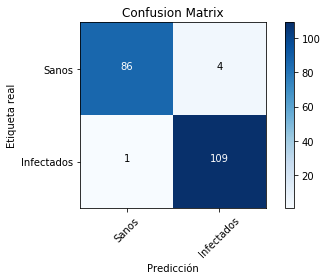

In [44]:
# Representamos la Confusion Matrix especificando las etiquetas
cm_plot_etiquetas = ['Sanos', 'Infectados']
plot_confusion_matrix(cm, cm_plot_etiquetas, title='Confusion Matrix')

### Informe de clasificación

In [45]:
# Obtenemos los nombres de los archivos, etiquetas y predicciones asociadas y gracias al procesamiento del
# generator, procedemos a obtener un informe de clasificación
test_nombres = gen_test.filenames
# Obtenemos las etiquetas reales
y_real = gen_test.classes
# Así como las predicciones
y_prediccion = predicciones.argmax(axis=1)
# Y generamos un archivo de clasificación a modo de informe
clasificacion = classification_report(y_real, y_prediccion, target_names=cm_plot_etiquetas)
print(clasificacion)

              precision    recall  f1-score   support

       Sanos       0.99      0.96      0.97        90
  Infectados       0.96      0.99      0.98       110

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



## 10. Referencias

Listado de webs a las que se ha hecho referencia en distintas células del código:

**Cell 36**: Arquitectura del modelo de red neuronal convolucional https://gist.github.com/Mishaall/f52e717eae11080c4fc530e9ef5082ff

**Cell 38**: *How to Check-Point Deep Learning Models in Keras* https://machinelearningmastery.com/check-point-deep-learning-models-keras/